In [ ]:
!pip install pysal

In [5]:
import json
import pandas as pd
import requests
import geopandas as gpd
from matplotlib import pyplot as plt
import os
import time
import pysal
import numpy as np

In [158]:
import esda
import splot
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster
from pysal.model import spreg
from splot.libpysal import plot_spatial_weights

In [2]:
plt.style.use('dark_background')

## Tarefa 1
Produza um mapa de alta qualidade do shapefile crime_mg utilizando a extensão tmap. Apresente o código completo e o mapa produzido em sua resposta.

In [3]:
mg = gpd.read_file('crime_mg/crime_mg.shp').set_index('ID')

print('Shape', mg.shape)

mg.head()

Shape (754, 17)


,CODMUNI,MUNIC,AREA,INDICE94,INDICE95,GINI_91,POP_94,POP_RUR,POP_URB,POP_FEM,POP_MAS,POP_TOT,URBLEVEL,PIB_PC,X_COORD,Y_COORD,geometry
ID,,,,,,,,,,,,,,,,,
0,10,Abadia dos Dourados,897.4,11.22,17.28,0.5372,6291,2980,3512,3146,3346,6492,0.541,3649,-47.49321,-18.37060,"POLYGON ((-47.45302 -18.50364, -47.45026 -18.4..."
1,20,Abaeté,1822.4,32.88,36.57,0.6034,21257,4745,15944,10390,10299,20689,0.771,4124,-45.38105,-19.09786,"POLYGON ((-45.09001 -19.06712, -45.08627 -19.0..."
2,30,Abre-Campo,636.4,4.47,7.46,0.5643,19106,13191,5770,9331,9630,18961,0.304,2147,-42.43796,-20.36600,"POLYGON ((-42.52753 -20.42284, -42.52536 -20.4..."
3,40,Acaiaca,101.2,9.20,10.15,0.5069,3679,1679,1910,1793,1796,3589,0.532,1720,-43.10176,-20.40832,"POLYGON ((-43.13983 -20.45403, -43.13855 -20.4..."
4,50,Açucena,1172.2,8.90,10.41,0.5163,24318,10784,14065,12441,12408,24849,0.566,1569,-42.40581,-19.08302,"POLYGON ((-42.33825 -19.23248, -42.35319 -19.2..."


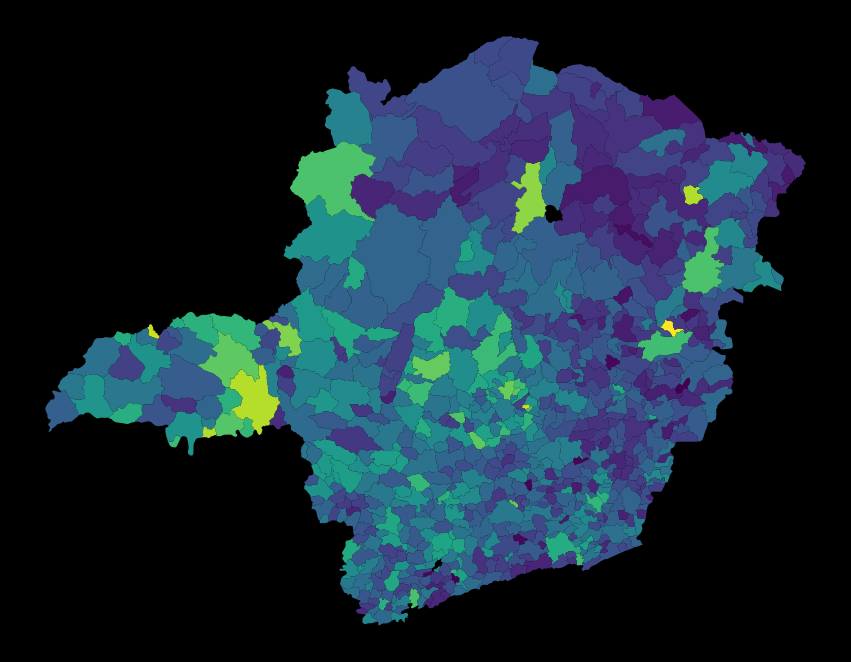

In [161]:
ax = mg.plot(column = 'INDICE95', figsize = (15,15))

ax.set_axis_off()

plt.show()

## Pergunta 2
Qual das variáveis quantitativas apresentadas no shapefile crime_mg apresenta maior auto-correlação espacial? Descreva como implementou a matriz de vizinhança. Apresente o I de Moran e o mapa de auto-correlação espacial local (LISA map) da variável escolhida e também de pelo menos outras 3 variáveis.

*Obs: desconsidere as variáveis Codmuni, ID, X_coord e Y_coord nessa análise.*

In [116]:
w = pysal.lib.weights.Queen.from_dataframe(mg)

w.transform = 'r'

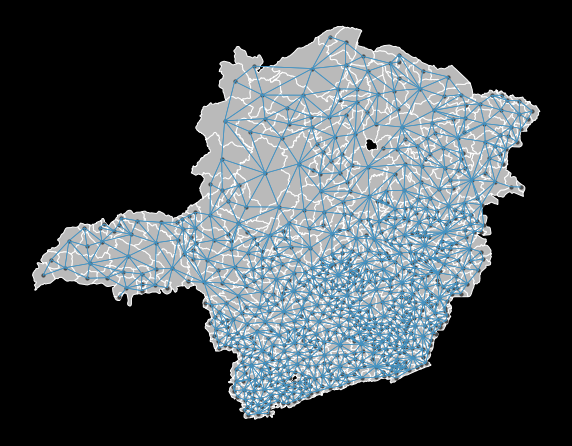

In [159]:
plot_spatial_weights(w, mg)
plt.show()

In [66]:
moran_I = {}
moran = {}
moran_local = {}

for i in mg.columns[2:-3]:
    
    moran[i] = esda.Moran(mg[i].values, w)
    moran_local[i] = esda.moran.Moran_Local(mg[i].values, w)
    moran_I[i] = moran[i].I


In [43]:
(pd.Series(moran_I)
     .rename('Moran I')
     .sort_values(ascending = False)
     .to_frame()
)

,Moran I
AREA,0.551408
INDICE94,0.315766
INDICE95,0.302518
URBLEVEL,0.291335
POP_RUR,0.242135
GINI_91,0.130387
POP_94,0.130170
POP_MAS,0.126523
PIB_PC,0.122221
POP_TOT,0.121612


AREA


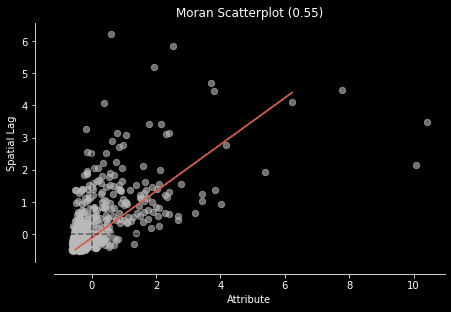

INDICE94


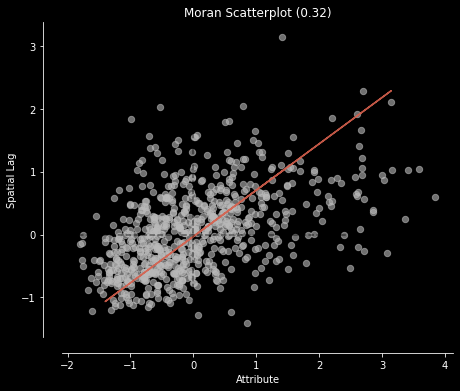

INDICE95


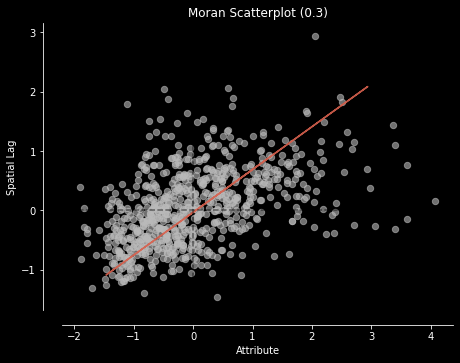

URBLEVEL


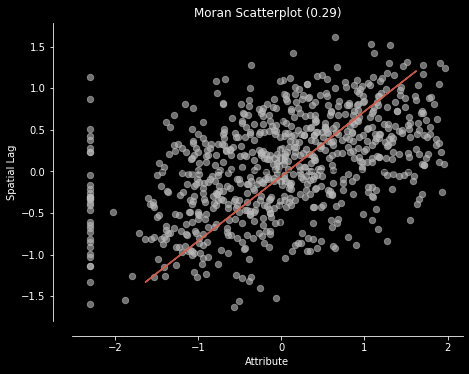

In [62]:
n = 4

for i in sorted(moran_I.items(), key=lambda x: x[1], reverse=True)[:n]:
    print(i[0])
    moran_scatterplot(moran[i[0]], aspect_equal=True)
    plt.show()

AREA


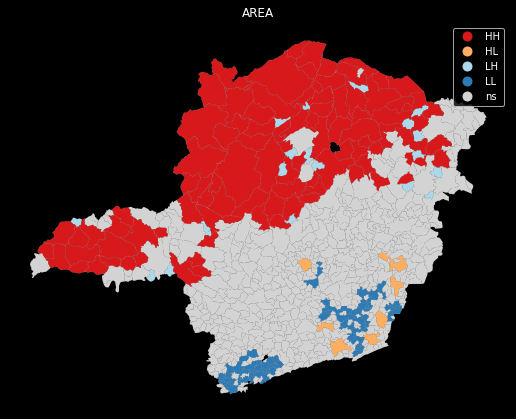

INDICE94


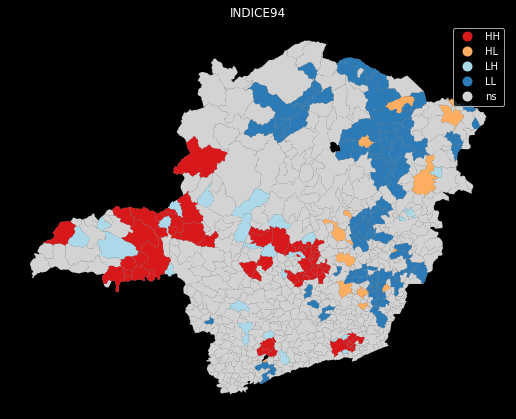

INDICE95


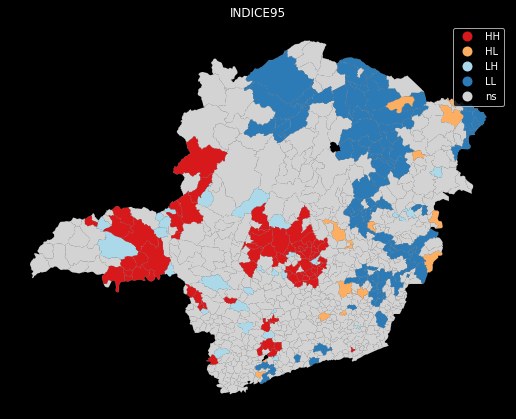

URBLEVEL


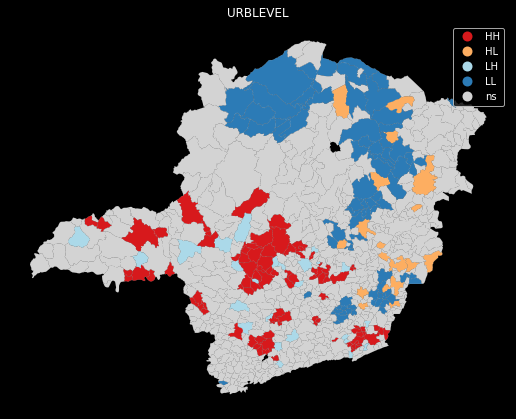

In [70]:
n = 4

for i in sorted(moran_I.items(), key=lambda x: x[1], reverse=True)[:n]:
    print(i[0])

    fig, ax = lisa_cluster(moran_local[i[0]], mg, p=0.05, figsize = (9,9))
    ax.set_title(i[0])
    plt.show()

## Pergunta 3
Implemente o modelo espacial auto-regressivo (SAR) da variável Indice95 (índice de criminalidade em 1995 de Minas Gerais) a partir de apenas uma variável independente (não pode ser Indice94, Codmuni, ID, X_coord nem Y_coord). Apresente o resultado da regressão linear simples e da regressão linear espacial. Apresente as equações e interprete seus coeficientes. Indique como criou a matriz de vizinhança.

In [83]:
import statsmodels.api as sm

In [119]:
x = 'URBLEVEL'
y = 'INDICE95'

In [151]:
lm = sm.OLS(
    mg[y],
    sm.add_constant(mg[[x]])
    
    ).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               INDICE95   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     253.6
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           2.03e-49
Time:                        22:50:29   Log-Likelihood:                -2519.2
No. Observations:                 754   AIC:                             5042.
Df Residuals:                     752   BIC:                             5052.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3208      0.625     10.112      0.000       5.094       7.548
URBLEVEL      16.9877      1.067     15.925      0.000      14.894      19.082
==============================================================================
Omnibus:                      149.924   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              314.447
Skew:                           1.103   Prob(JB):                     5.23e-69
Kurtosis:                       5.267   Cond. No.                         5.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

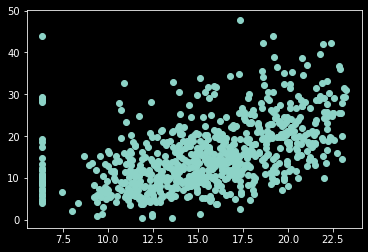

In [152]:
plt.scatter(
    lm.predict(sm.add_constant(mg[[x]])),
    mg[y])
plt.show()

In [124]:
print(
    spreg.OLS(
        x = mg[[x]].values, 
        y = mg[y].values[:, None], 
        w = w,
    
        
    ).summary
)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:         754
Mean dependent var  :     15.4488                Number of Variables   :           2
S.D. dependent var  :      7.9099                Degrees of Freedom    :         752
R-squared           :      0.2522
Adjusted R-squared  :      0.2512
Sum squared residual:   35231.453                F-statistic           :    253.5989
Sigma-square        :      46.850                Prob(F-statistic)     :   2.029e-49
S.E. of regression  :       6.845                Log likelihood        :   -2519.182
Sigma-square ML     :      46.726                Akaike info criterion :    5042.363
S.E of regression ML:      6.8356                Schwarz criterion     :    5051.614

-----------------------------------------------------------------------------

In [186]:
spatial_regression = spreg.GM_Lag(
        x = mg[[x]].values, name_x = [x],
        y = mg[y].values[:, None], name_y = y,
        w = w,
    
        
    )

print(
    spatial_regression.summary
)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :    INDICE95                Number of Observations:         754
Mean dependent var  :     15.4488                Number of Variables   :           3
S.D. dependent var  :      7.9099                Degrees of Freedom    :         751
Pseudo R-squared    :      0.3381
Spatial Pseudo R-squared:  0.2902

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.8769116       1.0320838       0.8496515       0.3955189
            URBLEVEL      12.8020945       1.1959630      10.7044231       0.0000000
          W_INDICE95       0.4862129       0.0758013       

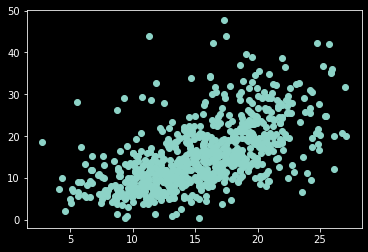

In [157]:
plt.scatter(spatial_regression.predy, mg[y])

In [165]:
mg_predictions = mg.copy()

In [175]:
mg_predictions['prediction'] = spatial_regression.predy
mg_predictions['erro'] = np.abs(mg_predictions['prediction'] - mg_predictions[y])

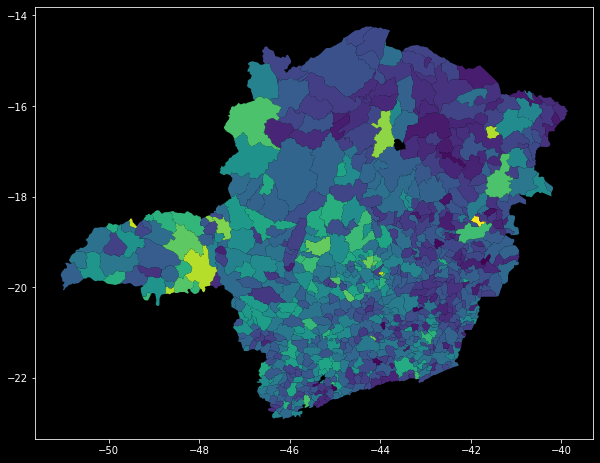

In [167]:
mg_predictions.plot(column = y, figsize = (10,10))

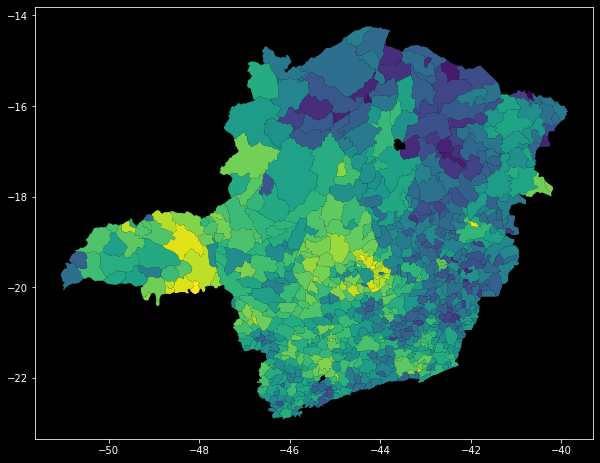

In [176]:
mg_predictions.plot(column = 'prediction', figsize = (10,10))

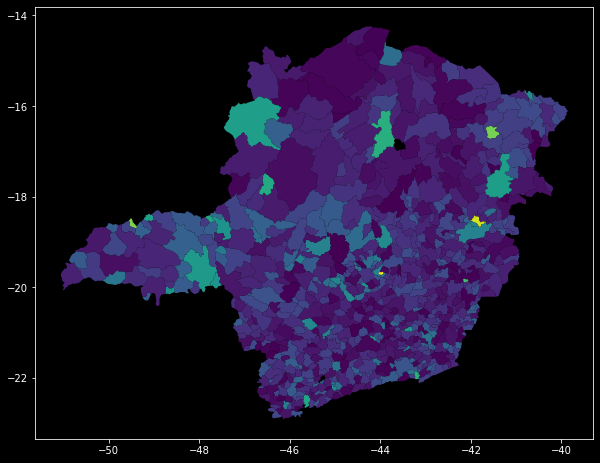

In [177]:
mg_predictions.plot(column = 'erro', figsize = (10,10))

## Pergunta 4
Para essa variável que você escolheu, o modelo espacial SAR apresentou ganhos significantes com relação ao modelo linear simples? Justifique sua resposta.
Obs: Sugere-se fazer essa atividade no GeoDA ou no R.

## Pergunta 5
Implemente a regressão espacial GWR da variável Indice95 (índice de criminalidade em 1995 de Minas Gerais) a partir de apenas uma variável independente (não pode ser Indice94, Codmuni, ID, X_coord nem Y_coord). Apresente o resultado da regressão linear simples e da regressão linear espacial por GWR. Apresente medidas da distribuição dos coeficientes (min, Q1, Q2, Q3, máx), e da distribuição do R2 (min, Q1, Q2, Q3, máx) e apresente os resultados globais da regressão (R2 global, basicamente). Destaque a estratégia utilizada para a construção do kernel (fixo ou adaptativo, vizinhança, etc).

*Obs: Sugere-se fazer essa atividade no ArcGIS ou no R.*

## Pergunta 6
Para essa variável que você escolheu, o modelo espacial GWR apresentou ganhos significantes com relação ao modelo linear simples? Justifique sua resposta.


## Pergunta 7
Implemente um modelo de regressão linear multivariado stepwise da variável Indice95 (significante a 5% ou 10%, utilize o que achar melhor). Depois, “promova-o” a um modelo SAR. Indique como criou a matriz de vizinhança. Apresente os resultados comparados (equação, R2). Qual modelo você escolheria como final? Se desejar, apresente mapas que sustente sua justificativa.

## Pergunta 8 (bônus)
Promova o modelo final linear da Pergunta 6 a um modelo GWR. Apresente os resultados comparados (equação, R2). Qual modelo você escolheria como final? Se desejar, apresente mapas que sustente sua justificativa. Destaque a estratégia utilizada para a construção do kernel (fixo ou adaptativo, vizinhança, etc).
Dica: utilize a extensão GWmodel ao invés da spgwr

In [82]:
inv = {'gold coin': 42, 'rope': 1}
dragonLoot = ['gold coin', 'dagger']

def addToInventory(inventory, addedItems):
    
    for i in addedItems:
        if i not in inventory:
            inventory[i] = 1
        else:
            inventory[i] = inventory[i] + 1
    
    return inventory
    
addToInventory(inv, dragonLoot)

{'gold coin': 43, 'rope': 1, 'dagger': 1}

In [75]:
'dagger' in inv

False